### import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from Signal_Tools import *

In [3]:
df = pd.read_csv('sim_signals_50k.csv')

In [4]:
len(df)

142140

In [5]:
df.head()

,HN00,HN01,HN02,HN03,HN04,HN05,HN06,HN07,HN08,HN09,...,LN21,LN22,LN23,LN24,LN25,LN26,LN27,LN28,LN29,Detector
0,28,61,61,49,39,32,36,34,27,23,...,13,10,12,11,11,11,11,11,11,441
1,12,19,15,15,13,14,14,13,14,11,...,15,15,13,14,14,15,12,12,12,441
2,17,43,56,64,64,91,119,105,94,94,...,11,11,12,10,14,10,13,11,10,358
3,17,29,22,19,23,24,38,66,97,180,...,13,9,9,9,8,10,11,12,9,357
4,36,82,74,48,39,34,34,38,41,36,...,52,42,33,28,21,20,17,20,17,357


### change the column names of the neighbour pad columns

In [6]:
df.columns = df.columns.str.replace('HN', 'AN')
df.columns = df.columns.str.replace('LN', 'BN')

In [7]:
df.head()

,AN00,AN01,AN02,AN03,AN04,AN05,AN06,AN07,AN08,AN09,...,BN21,BN22,BN23,BN24,BN25,BN26,BN27,BN28,BN29,Detector
0,28,61,61,49,39,32,36,34,27,23,...,13,10,12,11,11,11,11,11,11,441
1,12,19,15,15,13,14,14,13,14,11,...,15,15,13,14,14,15,12,12,12,441
2,17,43,56,64,64,91,119,105,94,94,...,11,11,12,10,14,10,13,11,10,358
3,17,29,22,19,23,24,38,66,97,180,...,13,9,9,9,8,10,11,12,9,357
4,36,82,74,48,39,34,34,38,41,36,...,52,42,33,28,21,20,17,20,17,357


## Supermodule 

The supermodule value can be computed by 

\begin{equation}
S_m = \frac{Detector}{N_{layer} \, N_{stack}} = \frac{Detector}{30}
\end{equation}

In [8]:
df['sm'] = df['Detector']//30

#### The total ADC sum of the signals $\sigma_{T}$

In [9]:
df['ADCSUM'] = df.iloc[:, :90].sum(axis=1)

### A look at some signals 

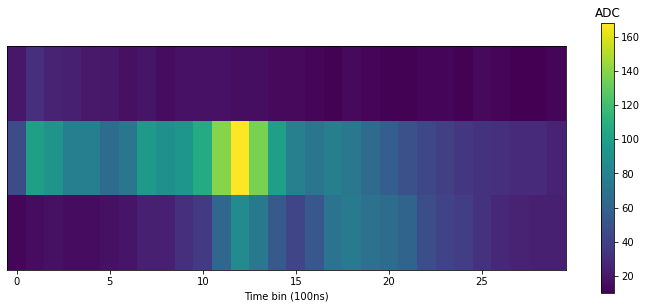

In [10]:
viz(df.iloc[344,:90].to_numpy().reshape(3,30))

This can be considered a fairly healthy signal 

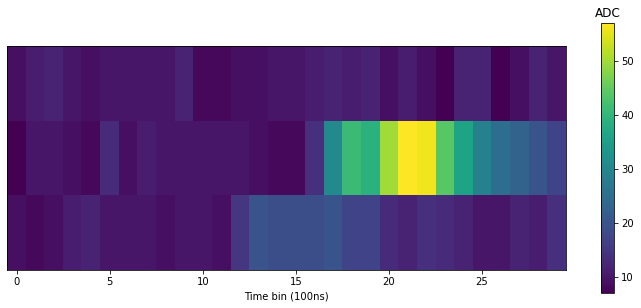

In [11]:
viz(df.iloc[760,:90].to_numpy().reshape(3,30))

This is a stripe like abnormality that is surely prevalent in the data sample and must be filtered out 

## Strategy to filter out "stripe-like" abnormalities 

Let the ADC value in the $i^{th}$ pad column at timebine $t$ be $\sigma_{it}$.


The ADC sum across all 30 time bins in the $i^{th}$ pad column is then 
\begin{equation}
    \sigma_i = \sigma_{i1} + \sigma_{i2} + ... + \sigma_{i30} =  \Sigma^{30}_{t=1} \sigma_{it}
\end{equation}

### Feature engineering 

In [12]:
# Max adc of the central pad column

df['MXmax'] = df.iloc[:, 30:60].max(axis=1)

# avg adc of the entire central pad column
df['MXavg'] = df.iloc[:, 30:60].mean(axis=1)

# Take ratio of avg over max 

df['MXRatio'] = df['MXavg']/df['MXmax']


# Now do the same for the A-neighbour pad column
df['Amax'] = df.iloc[:, :30].max(axis=1)
df['Aavg'] = df.iloc[:, :30].mean(axis=1)
df['ARatio'] = df['Aavg']/df['Amax']

# Perform the same for the B-neighbour 
df['Bmax'] = df.iloc[:, 60:90].max(axis=1)
df['Bavg'] = df.iloc[:, 60:90].mean(axis=1)
df['BRatio'] = df['Bavg']/df['Bmax']

# Compute the total adc sums in each individual pad column 
df['Asum'] = df.iloc[:, :30].sum(axis=1)
df['MXsum'] = df.iloc[:, 30:60].sum(axis=1)
df['Bsum'] = df.iloc[:, 60:90].sum(axis=1)

# Exploration of the data before cuts 

### Total ADC SUM distribution 


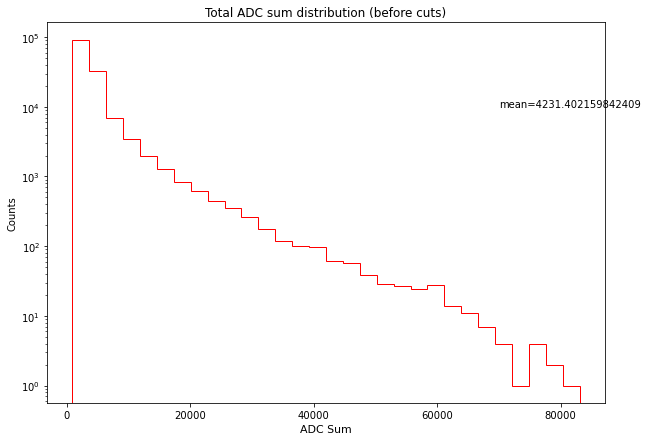

In [13]:
plt.figure(figsize=(10, 7))
plt.hist(df['ADCSUM'], histtype='step', edgecolor='red', bins=30, log=True)
plt.title("Total ADC sum distribution (before cuts)")
plt.xlabel("ADC Sum", fontsize=11)
plt.ylabel('Counts')
plt.text(70000, 10000, "mean={}".format(df['ADCSUM'].mean()))
plt.show()

### Plots of the Neighbouring pad ADC sums together with the total sum 


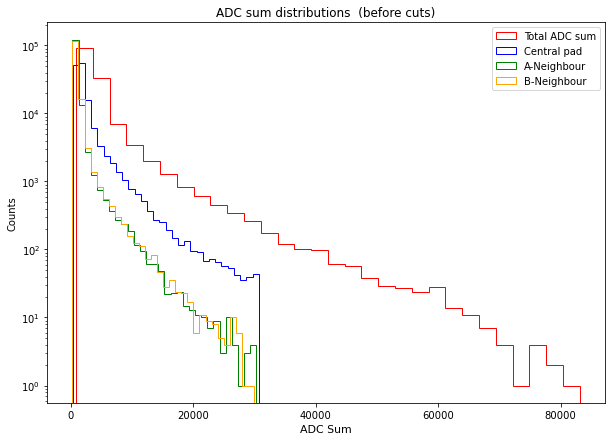

In [14]:
plt.figure(figsize=(10, 7))
plt.hist(df['ADCSUM'], histtype='step', edgecolor='red', bins=30, log=True, label="Total ADC sum")
plt.hist(df['MXsum'], histtype='step', edgecolor='blue', bins=30, log=True, label="Central pad")
plt.hist(df['Asum'], histtype='step', edgecolor='green', bins=30, log=True, label="A-Neighbour")
plt.hist(df['Bsum'], histtype='step', edgecolor='orange', bins=30, log=True, label="B-Neighbour")
plt.legend()
plt.title("ADC sum distributions  (before cuts)")
plt.xlabel("ADC Sum", fontsize=11)
plt.ylabel('Counts')
plt.show()

### $R_{\sigma_1}$  Distribution

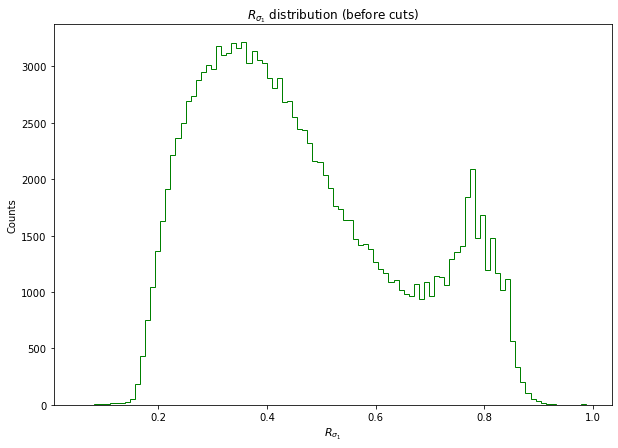

In [15]:
plt.figure(figsize=(10, 7))
plt.hist(df['ARatio'], histtype='step', edgecolor='green', bins=100)
plt.title("$R_{\sigma_1}$ distribution (before cuts)")
plt.xlabel("$R_{\sigma_1}$", fontsize=11)
plt.ylabel('Counts')
plt.show()

### $R_{\sigma_2}$ Distribution

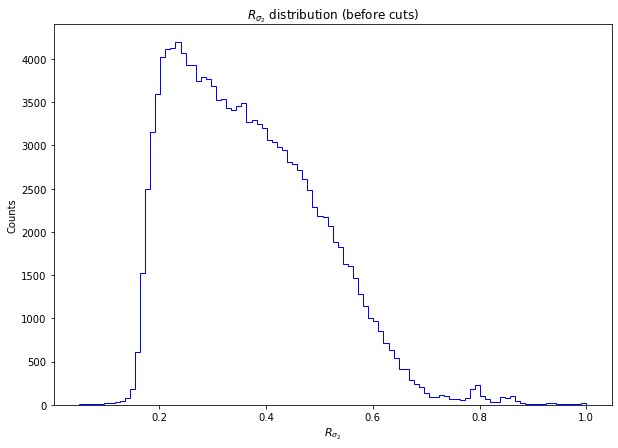

In [16]:
plt.figure(figsize=(10, 7))
plt.hist(df['MXRatio'], histtype='step', edgecolor='blue', bins=100)
plt.title("$R_{\sigma_2}$ distribution (before cuts)")
plt.xlabel("$R_{\sigma_2}$", fontsize=11)
plt.ylabel('Counts')
plt.show()

### $R_{\sigma_3}$ Distribution

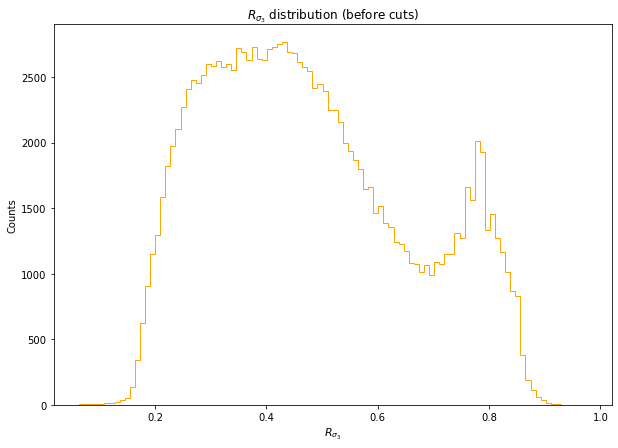

In [17]:
plt.figure(figsize=(10, 7))
plt.hist(df['BRatio'], histtype='step', edgecolor='orange', bins=100)
plt.title("$R_{\sigma_3}$ distribution (before cuts)")
plt.xlabel("$R_{\sigma_3}$", fontsize=11)
plt.ylabel('Counts')
plt.show()

# Quality Cuts 

We employ the folowing cuts to the data 

$1300 < \, \sigma_T \, < 30000$


$R_{\sigma_1} \, < 0.7$

$R_{\sigma_2} \, <0.7$

$R_{\sigma_3} \, < 0.7$

In [18]:
newdf = df[(df.ADCSUM>1300) & (df.ADCSUM<=30000) & (df.ARatio<0.7) & (df.MXRatio<0.7) & (df.BRatio<0.7)]

In [19]:
len(newdf)

100797

### Total ADC sum Distribution with cuts

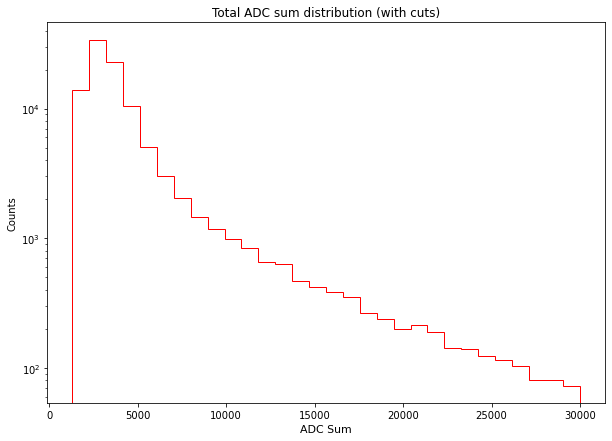

In [20]:
plt.figure(figsize=(10, 7))
plt.hist(newdf['ADCSUM'], histtype='step', edgecolor='red', bins=30, log=True)
plt.title("Total ADC sum distribution (with cuts)")
plt.xlabel("ADC Sum", fontsize=11)
plt.ylabel('Counts')
plt.show()

### Plots of the ADC sums of the neighbouring pad columns in relation to the central max and total adc sum with cuts

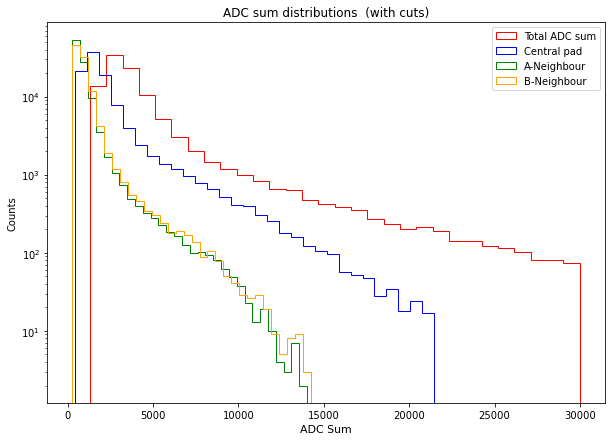

In [21]:
plt.figure(figsize=(10, 7))
plt.hist(newdf['ADCSUM'], histtype='step', edgecolor='red', bins=30, log=True, label="Total ADC sum")
plt.hist(newdf['MXsum'], histtype='step', edgecolor='blue', bins=30, log=True, label="Central pad")
plt.hist(newdf['Asum'], histtype='step', edgecolor='green', bins=30, log=True, label="A-Neighbour")
plt.hist(newdf['Bsum'], histtype='step', edgecolor='orange', bins=30, log=True, label="B-Neighbour")
plt.legend()
plt.title("ADC sum distributions  (with cuts)")
plt.xlabel("ADC Sum", fontsize=11)
plt.ylabel('Counts')
plt.show()

## $R_{\sigma_1}$ Distribution with cuts

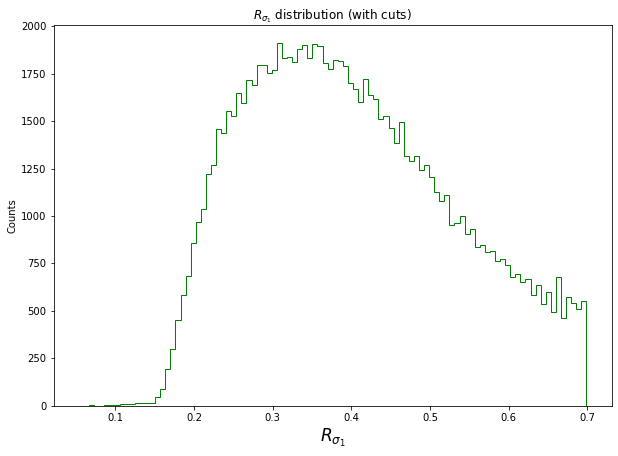

In [22]:
plt.figure(figsize=(10, 7))
plt.hist(newdf['ARatio'], histtype='step', edgecolor='green', bins=100)
plt.title("$R_{\sigma_1}$ distribution (with cuts)")
plt.xlabel("$R_{\sigma_1}$", fontsize=17)
plt.ylabel('Counts')
plt.show()

## $R_{\sigma_2}$ Distribution with cuts

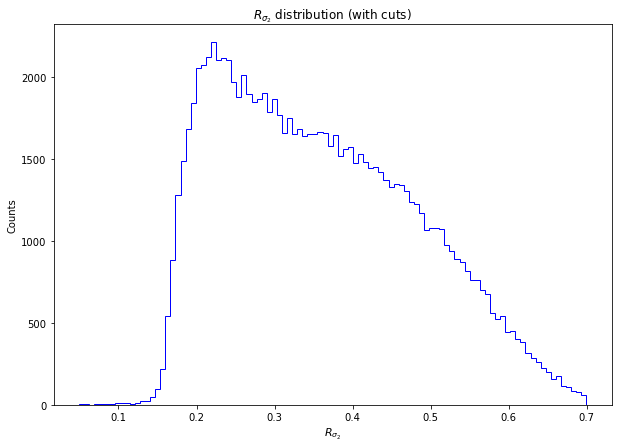

In [23]:
plt.figure(figsize=(10, 7))
plt.hist(newdf['MXRatio'], histtype='step', edgecolor='blue', bins=100)
plt.title("$R_{\sigma_2}$ distribution (with cuts)")
plt.xlabel("$R_{\sigma_2}$", fontsize=11)
plt.ylabel('Counts')
plt.show()

## $R_{\sigma_3}$ Distribution with cuts

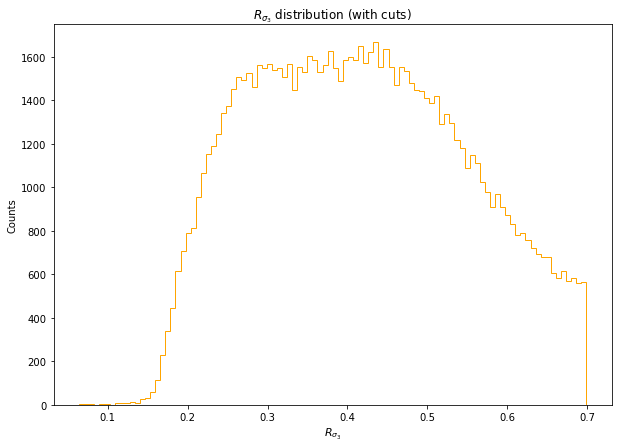

In [24]:
plt.figure(figsize=(10, 7))
plt.hist(newdf['BRatio'], histtype='step', edgecolor='orange', bins=100)
plt.title("$R_{\sigma_3}$ distribution (with cuts)")
plt.xlabel("$R_{\sigma_3}$", fontsize=11)
plt.ylabel('Counts')
plt.show()

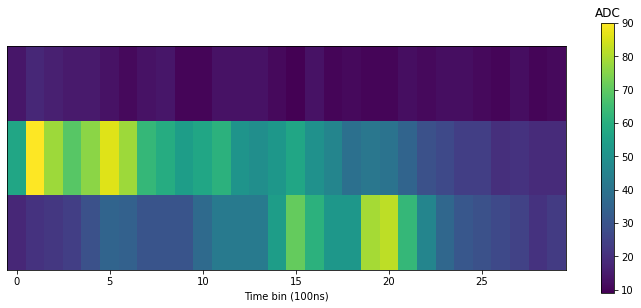

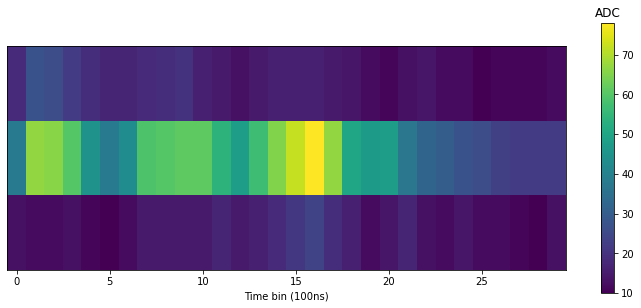

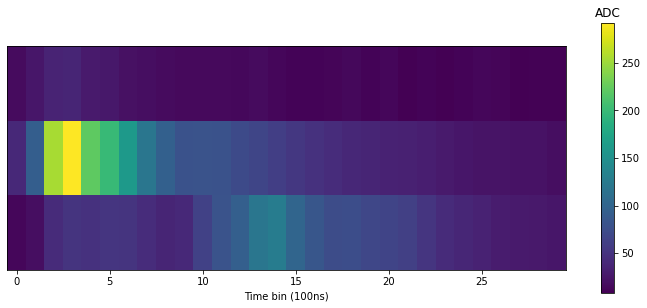

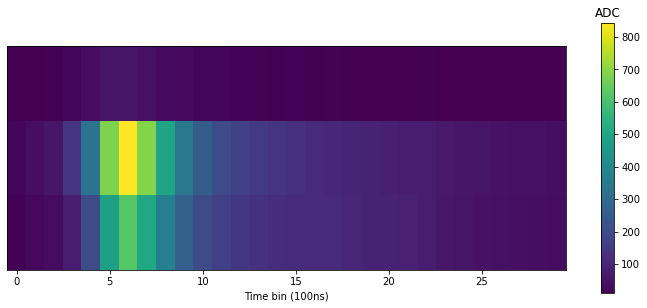

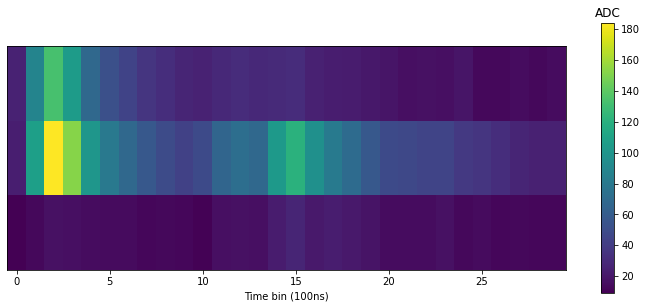

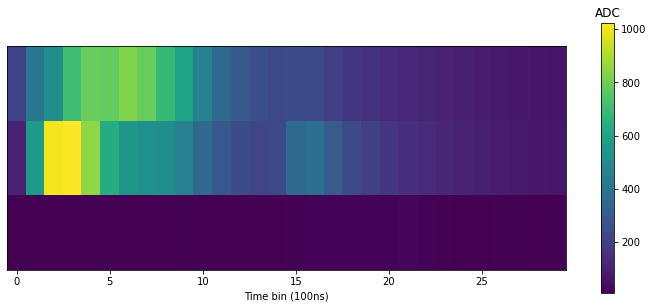

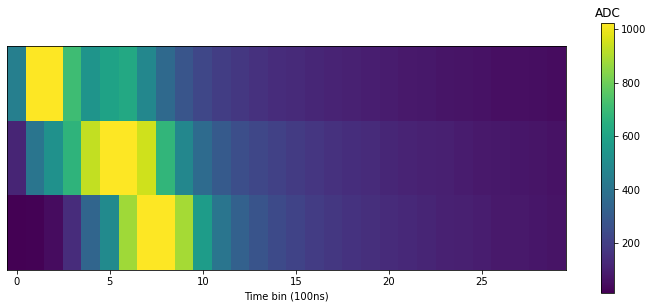

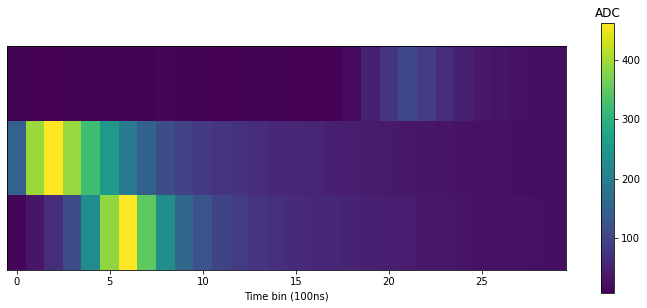

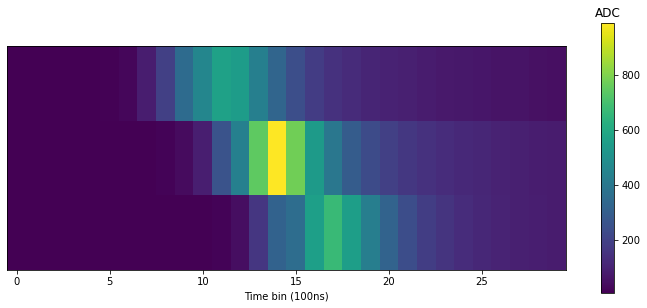

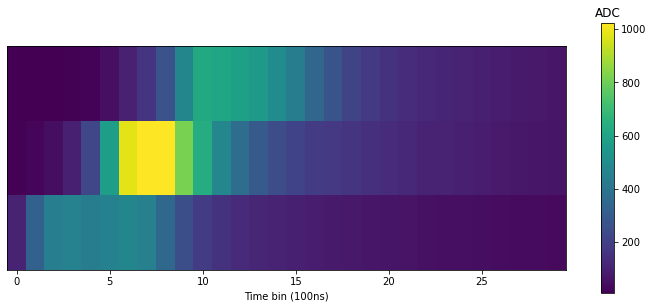

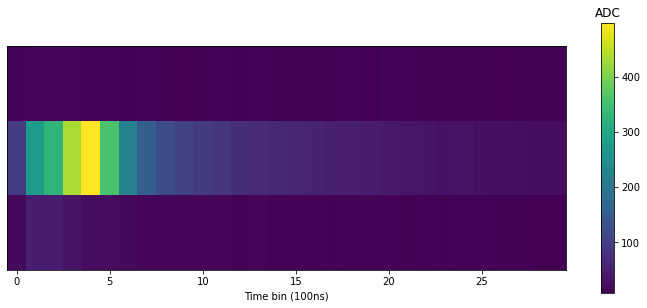

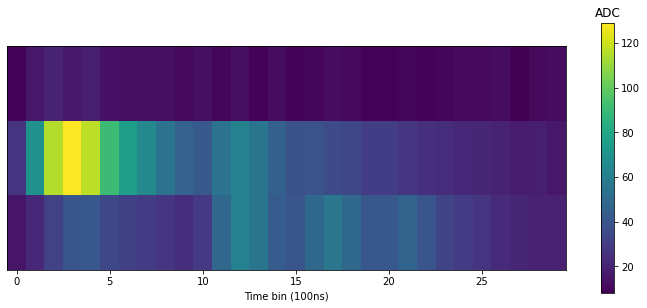

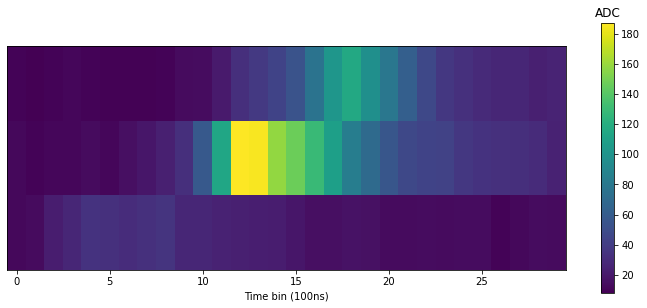

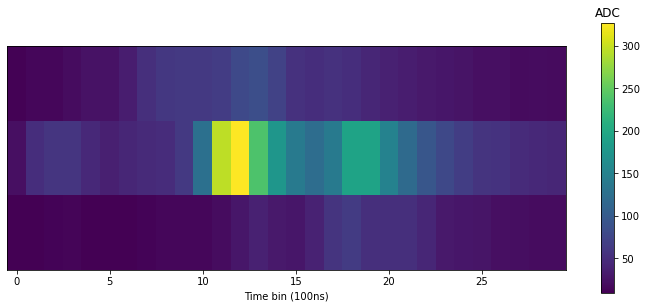

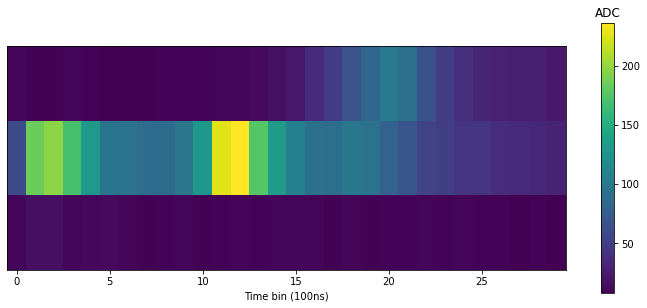

In [25]:
for j in range(15):
    viz(newdf.iloc[100+j,:90].to_numpy().reshape(3,30))

In [26]:
newdf.to_csv("Clean_simsigs_50k.csv", index=False)